https://github.com/uscensusbureau/acs-summary-file/wiki/Python-Table-Data-for-All-Tracts

According to the [data explorer notes](https://data.census.gov/table/ACSDT5Y2020.B16001?q=B16001:%20Language%20Spoken%20at%20Home%20by%20Ability%20to%20Speak%20English%20for%20the%20Population%205%20Years%20and%20Over), Public Use Microdata Sample Areas (PUMAs) (795) are the most precise available version of this dataset (for privacy reasons). More info about PUMAs [here](https://www.census.gov/programs-surveys/geography/guidance/geo-areas/pumas.htm). Less so are congressional districts (500), but seem easier to work with, so I'll start there.

In [1]:
import pandas as pd
from ftplib import FTP
import os, sys
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import lonboard
from lonboard import viz, Map, ScatterplotLayer
from lonboard.colormap import apply_categorical_cmap, DiscreteColormap
# from palettable.colorbrewer.diverging import BrBG_10
from lonboard.layer_extension import CollisionFilterExtension

import numpy as np
from shapely.geometry import Point
# from shapely.ops import unary_union
# from shapely import wkt
import random

## Loading Data

In [4]:
def table_for_sumlevel(tblid, year, dataset, sumlevel):

    #create output directory. 
    outdir = 'survey_data2'
    try:
        os.mkdir(outdir)
    except FileExistsError as e:
        print(f"directory named '{outdir}' already exists. delete it and try again.")
        sys.exit(1)

    dir =f"/programs-surveys/acs/summary_file/{year}/prototype/{dataset}YRData/"

    #go to ftp site
    ftp = FTP("ftp2.census.gov")
    ftp.login("","")
    ftp.cwd(dir)

    #get .dat file based on tblid or all tables
    files = [x for x in ftp.nlst() if f"{tblid}.dat" in x or (tblid=="*" and ".dat" in x)]

    for file in files:
        #read data file and query for summary level (http faster than ftp)
        df = pd.read_csv(f"https://www2.census.gov{dir}{file}", sep="|")
        df = df[ df['GEO_ID'].str.startswith(sumlevel) ]

        #output
        if not df.empty:
            df.to_csv(f"{outdir}/{file}", sep="|", index=False)
            print(f"{outdir}/{file} output.")

[Summary level definitions](https://mcdc.missouri.edu/geography/sumlevs/#:~:text=the%20U.S.-,Summary%20Levels,-All%20MCDC%20census)

Congress districts (500) (cd116) are less precise than the most precise version of languages spoken at home, which are PUMAs (795). However, I couldn't get the PUMA shapefiles to align perfectly with the PUMA-level languages spoken at home dataset (b16001).

In [6]:
#MARKDOWN CELL

#get one table for tracts (140)

table_for_sumlevel(tblid = 'c16001', year=2020, dataset=5, sumlevel='140')

directory named 'survey_data2' already exists. delete it and try again.


AssertionError: 

I need to re-do this workflow and instead of saving a .dat to an output directory and re-loading it, I can directly load it as a df

`GEO_ID` [explanation ](https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html#:~:text=The%20%E2%80%9CGEO.ID%E2%80%9D%20field%20contains%2014%2Ddigit%20codes%20that%20identify%20the%20summary%20level%20of%20data%2C%20the%20geographic%20component%20of%20the%20data%20and%20FIPS%20codes%20that%20uniquely%20identify%20the%20data)

In [2]:
df = pd.read_csv('survey_data/acsdt5y2020-c16001.dat', delimiter='|')

Table header labels [here](https://www2.census.gov/programs-surveys/acs/summary_file/2020/prototype/)

In [3]:
# Take last 11 digits of GEO_ID to make new column that matches the shapefile parameter 
df['GEO_ID_SHORT'] = df.GEO_ID.str[-11:]

In [4]:
# Make some initial calculations and add them as new columns
df['ONLY_ENG_PER'] = df.C16001_E002 / df.C16001_E001
# df['SPANISH_PER'] = df.B16001_E003 / df.B16001_E001
# df['FRENCH_PER'] = df.B16001_E006 / df.B16001_E001
# df['ITALIAN_PER'] = df.B16001_E012 / df.B16001_E001
# df['PORTUGUESE_PER'] = df.B16001_E015 / df.B16001_E001
# df['CHINESE_PER'] = df.B16001_E075 / df.B16001_E001

In [5]:
# issue with default encoding, so I'm "replacing" the text with issues (see https://docs.python.org/3/library/codecs.html#error-handlers)
df2 = pd.read_csv('ACS2020_Table_Shells.csv', encoding_errors="replace")
labels = df2[df2['Table ID'] == 'C16001']

In [6]:
# Get only the "language" rows, including the total

# add 2 for all people, 3 for only english speakers
initial_rows = [3, 4]

# Every 3rd row starting from row 8 (index 7)
# Calculate the end of the range to be the number of rows in the DataFrame
every_third_row = range(7, len(labels), 3)

# Combine the lists of indices
selected_indices = initial_rows + list(every_third_row)

# Use iloc to select the rows
selected_labels = labels.iloc[selected_indices]

# Add the letter "E" to make labels and dataset language codes match
selected_labels['lang_code'] = selected_labels['Unique ID'].apply(lambda x: x.replace('_', '_E'))

# Display the selected rows
selected_labels


/var/folders/mf/q66l1j8d7k3d1543fzt8qwfh0000gn/T/ipykernel_70423/955727189.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_labels['lang_code'] = selected_labels['Unique ID'].apply(lambda x: x.replace('_', '_E'))


,Table ID,Line,Unique ID,Stub,Data Release,lang_code
12604,C16001,2,C16001_002,Speak only English,NaN,C16001_E002
12605,C16001,3,C16001_003,Spanish:,NaN,C16001_E003
12608,C16001,6,C16001_006,"French, Haitian, or Cajun:",NaN,C16001_E006
12611,C16001,9,C16001_009,German or other West Germanic languages:,NaN,C16001_E009
12614,C16001,12,C16001_012,"Russian, Polish, or other Slavic languages:",NaN,C16001_E012
12617,C16001,15,C16001_015,Other Indo-European languages:,NaN,C16001_E015
12620,C16001,18,C16001_018,Korean:,NaN,C16001_E018
12623,C16001,21,C16001_021,"Chinese (incl. Mandarin, Cantonese):",NaN,C16001_E021
12626,C16001,24,C16001_024,Vietnamese:,NaN,C16001_E024
12629,C16001,27,C16001_027,Tagalog (incl. Filipino):,NaN,C16001_E027


In [26]:
# Have the language codes as a list, for processing later
all_lang = selected_labels['lang_code'].values.tolist()

# And all language codes + names as a dictionary
all_lang_dict = dict(zip(selected_labels.lang_code, selected_labels.Stub))

In [8]:
# Only keep columns that are needed. Make list with all lang column names, add a few extra important ones
keep_col = all_lang
keep_col.extend(['GEO_ID', 'GEO_ID_SHORT', 'only_eng_per'])

In [9]:
df = df[df.columns.intersection(keep_col)]
df

,GEO_ID,C16001_E002,C16001_E003,C16001_E006,C16001_E009,C16001_E012,C16001_E015,C16001_E018,C16001_E021,C16001_E024,C16001_E027,C16001_E030,C16001_E033,C16001_E036,GEO_ID_SHORT
0,1400000US01001020100,1829,5,5,0,0,0,0,0,0,4,0,0,0,01001020100
1,1400000US01001020200,1640,0,0,11,0,0,0,0,0,0,0,0,0,01001020200
2,1400000US01001020300,3304,221,0,0,17,0,0,0,18,13,13,0,0,01001020300
3,1400000US01001020400,3227,18,0,0,2,0,0,0,0,0,17,0,145,01001020400
4,1400000US01001020501,3591,56,0,0,184,1,0,0,0,28,52,0,0,01001020501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85390,1400000US72153750501,489,4448,0,0,0,0,0,0,0,0,0,0,0,72153750501
85391,1400000US72153750502,212,2385,0,0,0,0,0,0,0,0,0,0,0,72153750502
85392,1400000US72153750503,152,1822,18,0,0,0,0,0,0,0,0,0,0,72153750503
85393,1400000US72153750601,395,3922,0,0,0,0,0,0,0,0,0,0,0,72153750601


Add [2020 shapefiles](https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.2020.html#list-tab-1883739534) at 5m resolution (for census tracts)

In [10]:
# Census tracts
shp = gpd.read_file('geos/cb_2020_us_tract_500k.zip')

In [14]:
# merge geographic file and survey data, turn it into a GeoDataFrame
joined = gpd.GeoDataFrame(pd.merge(df, shp, how="inner" , left_on='GEO_ID_SHORT', right_on='GEOID'))
joined.head()

,GEO_ID,C16001_E002,C16001_E003,C16001_E006,C16001_E009,C16001_E012,C16001_E015,C16001_E018,C16001_E021,C16001_E024,...,GEOID,NAME,NAMELSAD,STUSPS,NAMELSADCO,STATE_NAME,LSAD,ALAND,AWATER,geometry
0,1400000US01001020100,1829,5,5,0,0,0,0,0,0,...,01001020100,201,Census Tract 201,AL,Autauga County,Alabama,CT,9825304,28435,"POLYGON ((-86.50910 32.47349, -86.50577 32.475..."
1,1400000US01001020200,1640,0,0,11,0,0,0,0,0,...,01001020200,202,Census Tract 202,AL,Autauga County,Alabama,CT,3320818,5669,"POLYGON ((-86.48093 32.48154, -86.47945 32.485..."
2,1400000US01001020300,3304,221,0,0,17,0,0,0,18,...,01001020300,203,Census Tract 203,AL,Autauga County,Alabama,CT,5349271,9054,"POLYGON ((-86.47087 32.47573, -86.46964 32.478..."
3,1400000US01001020400,3227,18,0,0,2,0,0,0,0,...,01001020400,204,Census Tract 204,AL,Autauga County,Alabama,CT,6384282,8408,"POLYGON ((-86.45394 32.49318, -86.45308 32.493..."
4,1400000US01001020501,3591,56,0,0,184,1,0,0,0,...,01001020501,205.01,Census Tract 205.01,AL,Autauga County,Alabama,CT,6203654,0,"POLYGON ((-86.43826 32.45293, -86.43640 32.455..."


## Explore data

In [33]:
# Make GeoDataFrames with subset of information for some languages

only_eng_per = joined[["GEO_ID", "C16001_E001", "C16001_E002", "ONLY_ENG_PER", "geometry"]]

<Axes: >

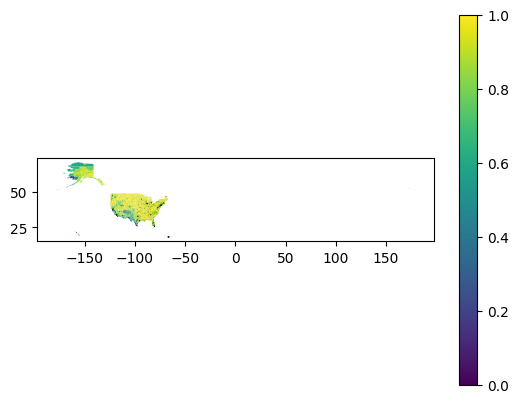

In [34]:
only_eng_per.plot("ONLY_ENG_PER", legend=True)

## Sampled points

https://geopandas.org/en/stable/docs/user_guide/sampling.html

https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.sample_points.html

Another approach, from ChatGPT

In [24]:
gdf = gpd.GeoDataFrame(joined)

In [20]:
def generate_random_points(poly, num_points):
    minx, miny, maxx, maxy = poly.bounds
    points = []

    while len(points) < num_points:
        random_point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if random_point.within(poly):
            points.append(random_point)
    
    return points

In [34]:
# Assign random colors (x, y, z) to each language
language_color_map = {language: [random.randint(0, 255) for _ in range(3)] for language in all_lang}
language_color_map


{'C16001_E002': [170, 197, 201],
 'C16001_E003': [159, 240, 169],
 'C16001_E006': [149, 221, 222],
 'C16001_E009': [89, 236, 10],
 'C16001_E012': [1, 34, 110],
 'C16001_E015': [249, 32, 116],
 'C16001_E018': [117, 203, 144],
 'C16001_E021': [29, 191, 12],
 'C16001_E024': [4, 227, 240],
 'C16001_E027': [93, 180, 180],
 'C16001_E030': [64, 27, 52],
 'C16001_E033': [180, 151, 255],
 'C16001_E036': [26, 96, 226]}

In [31]:
points_list = []
for index, row in gdf.iterrows():
    poly = row['geometry']
    for lang in all_lang:
        num_speakers = row[lang]
        num_points = num_speakers // 250  # Assuming one dot represents X speakers
        points = generate_random_points(poly, num_points)
        for point in points:
            points_list.append({'geometry': point, 'language': lang})


In [32]:
# Not quite sure what this does...
points_gdf = gpd.GeoDataFrame(points_list, crs=gdf.crs)

# Add a new column, language_name, to the geodataframe based on the key in the language column and the value from the all_lang_dict dictionary
points_gdf['language_name'] = points_gdf['language'].map(all_lang_dict)

# points_gdf.to_file('export/c16001_all_lang_no_eng_250.geojson', driver='GeoJSON')

In [73]:
# makes sure that the lanugage column values are strings, to match language_color_map
points_gdf.astype({'language':'string', 'language_name':'string'})

,geometry,language,language_name
0,POINT (-86.48782 32.49253),C16001_E002,Speak only English
1,POINT (-86.50194 32.48252),C16001_E002,Speak only English
2,POINT (-86.48770 32.48915),C16001_E002,Speak only English
3,POINT (-86.48695 32.45327),C16001_E002,Speak only English
4,POINT (-86.49275 32.46657),C16001_E002,Speak only English
...,...,...,...
1101225,POINT (-66.86211 17.98747),C16001_E003,Spanish:
1101226,POINT (-66.84404 17.97401),C16001_E003,Spanish:
1101227,POINT (-66.85860 17.97435),C16001_E003,Spanish:
1101228,POINT (-66.86179 17.96227),C16001_E003,Spanish:


In [36]:
layer = ScatterplotLayer.from_geopandas(
    points_gdf,
    get_fill_color = apply_categorical_cmap(points_gdf.language, language_color_map),
    radius_scale = 50,
    opacity = 1,
    billboard = True,
    auto_downcast = True,
    )
m = Map(
    layers=[layer],
    _height=600,
    basemap_style = lonboard.basemap.CartoBasemap.DarkMatter
    )
m


/Users/will/.pyenv/versions/3.8.12/lib/python3.8/site-packages/lonboard/_geoarrow/ops/reproject.py:78: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…